In [ ]:
!rm -rf /content/light-transport

In [ ]:
!git clone https://github.com/dipanjan92/light-transport.git

In [ ]:
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [ ]:
!pip install pyvista

In [ ]:
import os
os.chdir('/content/light-transport/')
os.getcwd()

In [1]:
import math
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.src.constants import *

In [3]:
#load object
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)

10

In [4]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

padding = 5
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(2.5, 2.0, 1.7320508, 7.5)

In [5]:
# empty object list
objects = numba.typed.List()

In [6]:
start_id = len(objects)
surface_color = WHITE_2
left_wall_color = GREEN
right_wall_color = RED
surface_mat = Material(color=surface_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)

objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat, start_id)

In [7]:
id = len(objects)+1
for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)
    id+=1
    triangle = PreComputedTriangle(id=id,
                                   vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

ListType[instance.jitclass.PreComputedTriangle#1e449896800<type:int64,id:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#1e44c01f250<color:instance.jitclass.Color#1e44bfd1ff0<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001E44DE56EF0>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001E44DE578B0>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001E44DE56EF0>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001E44DE578

In [8]:
# global light source
light_sources = numba.typed.List()

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5, emission=200)

id = len(objects)+1

light_1 = PreComputedTriangle(id=id,
                              vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)
id += 1

light_2 = PreComputedTriangle(id=id,
                              vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)


light_samples = 10
a = np.random.uniform(0,1,light_samples)
b = np.random.uniform(1,0,light_samples)

for x in range(light_samples):
    tp1 = light_1.vertex_1 * (1-math.sqrt(a[x])) + light_1.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_1.vertex_3 * (b[x]*math.sqrt(a[x]))
    l1 = Light(source=tp1, material=source_mat, normal=light_1.normal, total_area=4)
    light_sources.append(l1)
    tp2 = light_2.vertex_1 * (1-math.sqrt(a[x])) + light_2.vertex_2 * (math.sqrt(a[x])*(1-b[x])) + light_2.vertex_3 * (b[x]*math.sqrt(a[x]))
    l2 = Light(source=tp1, material=source_mat, normal=light_2.normal, total_area=4)
    light_sources.append(l2)

light_sources

ListType[instance.jitclass.Light#1e44bfd24d0<source:array(float64, 1d, A),material:instance.jitclass.Material#1e44c01f250<color:instance.jitclass.Color#1e44bfd1ff0<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>,normal:array(float64, 1d, A),total_area:float64>]([<numba.experimental.jitclass.boxing.Light object at 0x000001E4513CF730>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4512417E0>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4513CF730>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4512417E0>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4513CF730>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4512417E0>, <numba.experimental.jitclass.boxing.Light object at 0x000001E4513CF730>, <numba.experimental.jitclass.boxing.Light object at 0x000001E45

In [9]:
objects.append(light_1)
objects.append(light_2)

In [10]:
# setup scene

#camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

#screen
width=100
height=100
max_depth=5

#scene
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, depth=depth)

In [11]:
from LightTransportSimulator.light_transport.src.primitives import AABB
# min_point=np.array([scene.left, scene.bottom, -scene.depth], dtype=np.float64)
# max_point=np.array([scene.right, scene.top, scene.depth], dtype=np.float64)
min_point=np.array([-depth, -depth, depth], dtype=np.float64)
max_point=np.array([depth, depth, -depth], dtype=np.float64)
box = AABB(min_point=min_point, max_point=max_point)
box

In [12]:
from LightTransportSimulator.light_transport.src.bvh import BVH

bvh = BVH()
bvh.insert(objects, box)

In [13]:
from LightTransportSimulator.light_transport.src.path_tracing import render_scene

start = time.time()
image = render_scene(scene, bvh.top, number_of_samples=10)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\path_tracing.py:152: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  color += trace_path(scene, bvh, ray.origin, ray.direction, 0)


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
3.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
4.0
4.0
3.0
4.0
4.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
4.0
6.0
6.0
5.0
5.0
6.0
6.0
6.0
7.000000000000001
7.000000000000001
7.000000000000001
5.0
6.0
6.0
7.000000000000001
8.0
8.0
7.000000000000001
8.0
8.0
7.000000000000001
7.000000000000001
9.0
9.0
6.0
9.0
8.0
9.0
8.0
10.0
8.0
10.0
10.0
7.000000000000001
9.0
10.0
11.0
9.0
9.0
11.0
11.0
12.0
10.0
8.0
11.0
10.0
12.0
10.0
12.0
13.0
11.0
11.0
13.0
12.0
13.0
11.0
9.0
12.0
12.0
12.0
10.0
11.0
12.0
13.0
Elapsed (with compilation) = 477.8093149662018


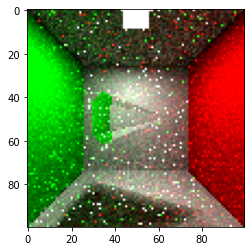

In [14]:
plt.imshow(image)

In [15]:
from LightTransportSimulator.light_transport.src.vectors import normalize
from LightTransportSimulator.light_transport.src.rays import Ray

origin = np.array([0, 0 , 0], dtype=np.float64)
end = np.array([1, 1, 1], dtype=np.float64)
direction = normalize(end - origin)
ray = Ray(origin, direction)
ray

In [18]:
print(direction, ray.direction)

[0.57735027 0.57735027 0.57735027] [0.57735027 0.57735027 0.57735027 0.        ]


In [19]:
print(origin, ray.origin)

[0. 0. 0.] [0. 0. 0. 1.]
